In [1]:
import pandas as pd
import os

base_path = os.path.dirname(os.getcwd())
download_path = os.path.join(base_path, "download")
csv_file = os.path.join(download_path, "USDCHF_5_year.csv")

# Cargar el archivo
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)

    # Convertir la columna de tiempo si no está ya
    df['time'] = pd.to_datetime(df['time'])

    # Mostrar las primeras filas
    print("Primeras filas del dataset:")
    print(df.head())
else:
    print("❌ El archivo no fue encontrado en la ruta especificada:")
    print(csv_file)


Primeras filas del dataset:
                 time     open     high      low    close  tick_volume  \
0 2020-05-07 00:00:00  0.97482  0.97521  0.97460  0.97465          316   
1 2020-05-07 01:00:00  0.97465  0.97509  0.97465  0.97496          806   
2 2020-05-07 02:00:00  0.97494  0.97545  0.97492  0.97531         1346   
3 2020-05-07 03:00:00  0.97530  0.97582  0.97478  0.97565         2193   
4 2020-05-07 04:00:00  0.97565  0.97572  0.97485  0.97497         1877   

   spread  real_volume  
0      10            0  
1       3            0  
2       3            0  
3       3            0  
4       3            0  


In [2]:
# Ver columnas con valores constantes (sin variabilidad)
print("\nColumnas con valores constantes:")
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
for col in constant_columns:
    print(f"- {col}: {df[col].unique()[0] if not df[col].isnull().all() else 'Todos nulos'}")

# Verificación de columnas con valores nulos
print("\nColumnas con valores nulos:")
for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        print(f"- {col}: {null_count} valores nulos ({null_count/len(df)*100:.2f}%)")
    else:
        print(f"- {col}: 0 valores nulos")



Columnas con valores constantes:
- real_volume: 0

Columnas con valores nulos:
- time: 0 valores nulos
- open: 0 valores nulos
- high: 0 valores nulos
- low: 0 valores nulos
- close: 0 valores nulos
- tick_volume: 0 valores nulos
- spread: 0 valores nulos
- real_volume: 0 valores nulos


In [3]:
df = df.drop(['real_volume', 'spread'], axis=1)

In [4]:
import pandas as pd
import numpy as np
import ta

# === 0. Asegurar que la columna de tiempo esté lista ===
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

# === 1. Calcular las 14 FEATURES TÉCNICAS según AIRMS-DT ===

# SMA comparisons
sma_200 = ta.trend.SMAIndicator(close=df['close'], window=200).sma_indicator()
sma_100 = ta.trend.SMAIndicator(close=df['close'], window=100).sma_indicator()
df['sma_200_vs_100'] = sma_200 - sma_100

sma_50 = ta.trend.SMAIndicator(close=df['close'], window=50).sma_indicator()
sma_25 = ta.trend.SMAIndicator(close=df['close'], window=25).sma_indicator()
df['sma_50_vs_25'] = sma_50 - sma_25

# RSI
df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()

# Momentum y aceleración
roc = ta.momentum.ROCIndicator(close=df['close'], window=12)
df['momentum_12'] = roc.roc()
df['acceleration_12'] = df['momentum_12'] - df['momentum_12'].shift(12)

# MACD (diferencia de macd - señal)
df['macd'] = ta.trend.MACD(close=df['close']).macd_diff()

# Estocástico %K
df['stoch_k'] = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close']).stoch()

# Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bb_middle'] = bb.bollinger_mavg()
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()

# Weighted Close
df['weighted_close'] = (2 * df['close'] + df['high'] + df['low']) / 4

# PoC 12 (Price of Change)
df['poc_12'] = (df['close'] - df['close'].shift(12)) / df['close'].shift(12)

# Canal de precios
df['high_channel_20'] = df['high'].rolling(window=20).max()
df['low_channel_20'] = df['low'].rolling(window=20).min()

# === 2. Función para construir MRB ===
def construir_mrb(df, brick_size=0.0010):
    mrb = []
    last_brick = df.iloc[0]['close']
    last_time = df.iloc[0]['time']
    for i in range(1, len(df)):
        price = df.iloc[i]['close']
        time = df.iloc[i]['time']
        diff = price - last_brick
        if abs(diff) >= brick_size:
            direction = 1 if diff > 0 else -1
            new_brick_price = last_brick + (brick_size * direction)
            mrb.append({'time': time, 'close': new_brick_price, 'direction': direction})
            last_brick = new_brick_price
    return pd.DataFrame(mrb)

# === 3. Señales tipo breakout sobre canal MRB ===
def generar_senal_mrb(mrb_df, Y=20):
    mrb_df['high_channel'] = mrb_df['close'].rolling(Y).max()
    mrb_df['low_channel'] = mrb_df['close'].rolling(Y).min()
    mrb_df['signal'] = 0
    buy = mrb_df['close'] > mrb_df['high_channel'].shift(1)
    sell = mrb_df['close'] < mrb_df['low_channel'].shift(1)
    mrb_df.loc[buy, 'signal'] = 1
    mrb_df.loc[sell, 'signal'] = -1
    return mrb_df

# === 4. Aplicar MRB y señales ===
mrb_df = construir_mrb(df, brick_size=0.0010)
mrb_df['time'] = pd.to_datetime(mrb_df['time'])
mrb_df.sort_values('time', inplace=True)
mrb_df = generar_senal_mrb(mrb_df, Y=20)

# === 5. Unir señales MRB al DataFrame original ===
df = pd.merge_asof(df, mrb_df[['time', 'signal']], on='time', direction='backward')
df['signal'] = df['signal'].fillna(0)

# === 6. Features MRB adicionales (6 total) ===

# Precio de cierre solo donde hay señal (signal ≠ 0)
df['precio_mrb'] = df['close'].where(df['signal'] != 0)

# Últimos 5 precios de señal anteriores
for i in range(1, 6):
    df[f'last_signal_price_{i}'] = df['precio_mrb'].shift(i)

# Diferencia absoluta entre precio actual y último precio de señal
df['abs_diff_mrb_vs_close'] = abs(df['close'] - df['precio_mrb'].ffill())

# Eliminar columna auxiliar
df.drop(columns=['precio_mrb'], inplace=True)

# === 7. Mostrar ejemplo final ===
print(df[[
    'time', 'close', 'signal', 'sma_200_vs_100', 'rsi_14',
    'acceleration_12', 'macd', 'stoch_k', 'momentum_12', 'bb_middle',
    'bb_upper', 'bb_lower', 'weighted_close', 'poc_12',
    'high_channel_20', 'low_channel_20', 'last_signal_price_1',
    'last_signal_price_2', 'last_signal_price_3', 'abs_diff_mrb_vs_close'
]].tail(10))


                     time    close  signal  sma_200_vs_100     rsi_14  \
31118 2025-05-05 14:00:00  0.82324     0.0        0.000611  42.285055   
31119 2025-05-05 15:00:00  0.82280     0.0        0.000632  40.780156   
31120 2025-05-05 16:00:00  0.82182     0.0        0.000663  37.572767   
31121 2025-05-05 17:00:00  0.82201     0.0        0.000701  38.581358   
31122 2025-05-05 18:00:00  0.82390     0.0        0.000726  47.643033   
31123 2025-05-05 19:00:00  0.82406     0.0        0.000726  48.337934   
31124 2025-05-05 20:00:00  0.82347     0.0        0.000728  45.917764   
31125 2025-05-05 21:00:00  0.82285     0.0        0.000736  43.455541   
31126 2025-05-05 22:00:00  0.82237     0.0        0.000753  41.595891   
31127 2025-05-05 23:00:00  0.82209     0.0        0.000762  40.506919   

       acceleration_12      macd    stoch_k  momentum_12  bb_middle  bb_upper  \
31118        -0.212409 -0.000015  23.049002    -0.118900   0.824915  0.828067   
31119         0.198875 -0.000068  

In [5]:
import pandas as pd
import numpy as np
from itertools import product

# === 1. Asegurar formato de fecha y ordenar ===
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

# === 2. División temporal ===
fecha_corte = df['time'].min() + pd.DateOffset(years=4)
df_train_full = df[df['time'] < fecha_corte].copy().reset_index(drop=True)
df_test = df[df['time'] >= fecha_corte].copy().reset_index(drop=True)

# === 3. Evaluación de una combinación de tp_pips y horizonte ===
def evaluar_combinacion(df_train, tp_pips, max_horizonte, X=138, Y=13, D=2):
    df = df_train.copy()
    df['label'] = 0

    for i in range(len(df) - max_horizonte):
        row = df.iloc[i]
        if row['signal'] == 0:
            continue

        entry_price = row['close']
        future = df.iloc[i + 1:i + 1 + max_horizonte]

        if row['signal'] == 1:
            if future['high'].max() >= entry_price + tp_pips:
                df.at[i, 'label'] = 1
        elif row['signal'] == -1:
            if future['low'].min() <= entry_price - tp_pips:
                df.at[i, 'label'] = 1

    total_signals = (df['signal'] != 0).sum()
    total_positives = (df['label'] == 1).sum()
    total_negatives = (df['label'] == 0).sum()
    ratio = total_positives / total_signals if total_signals > 0 else 0

    return df, {
        "tp_pips": tp_pips,
        "horizonte": max_horizonte,
        "X": X,
        "Y": Y,
        "D": D,
        "total_signals": total_signals,
        "label_1": total_positives,
        "label_0": total_negatives,
        "label_1_ratio": round(ratio, 4)
    }

# === 4. Lista extendida de tp_pips y horizontes ===
tp_pips_list = np.round(np.linspace(0.0005, 0.0050, num=15), 5).tolist()
horizontes = [12, 24, 36, 48]

# === 5. Probar todas combinaciones ===
resultados = []
dfs_resultado = {}

for tp, h in product(tp_pips_list, horizontes):
    df_etiquetado, stats = evaluar_combinacion(df_train_full, tp, h)
    resultados.append(stats)
    dfs_resultado[(tp, h)] = df_etiquetado

# === 6. Mostrar tabla ordenada por mejor balance ===
res_df = pd.DataFrame(resultados).sort_values(by="label_1_ratio", ascending=False)
print("\n📊 Combinaciones probadas de tp_pips, horizonte y parámetros MRB:")
print(res_df.to_string(index=False))

# === 7. Elegir mejor combinación ===
mejor_fila = res_df.iloc[0]
mejor_tp = mejor_fila['tp_pips']
mejor_h = mejor_fila['horizonte']
df_train = dfs_resultado[(mejor_tp, mejor_h)]

print(f"\n✅ Mejor combinación encontrada:")
print(f"🔸 tp_pips: {mejor_tp:.4f}")
print(f"🔸 Horizonte: {mejor_h} velas")
print(f"🔸 Parámetros MRB -> X = {mejor_fila['X']}, Y = {mejor_fila['Y']}, D = {mejor_fila['D']}")

# === 8. Guardar conjuntos finales ===
df_train.to_csv("df_train.csv", index=False)
df_test.to_csv("df_test.csv", index=False)

# === 9. Estadísticas finales ===
print("\n📌 Estadísticas con la mejor combinación:")
print(f"🔹 TP alcanzado (label = 1): {(df_train['label'] == 1).sum()}")
print(f"🔹 No alcanzó TP (label = 0): {(df_train['label'] == 0).sum()}")
print(f"🔹 Total señales activas: {(df_train['signal'] != 0).sum()}")
print(f"🔸 Total filas en df_train: {len(df_train)}")
print(f"🔸 Total filas en df_test: {len(df_test)}")
print(f"📊 Total filas en df original: {len(df)}")



📊 Combinaciones probadas de tp_pips, horizonte y parámetros MRB:
 tp_pips  horizonte   X  Y  D  total_signals  label_1  label_0  label_1_ratio
 0.00050         48 138 13  2           6720     6249    18687         0.9299
 0.00050         36 138 13  2           6720     6188    18748         0.9208
 0.00050         24 138 13  2           6720     6081    18855         0.9049
 0.00082         48 138 13  2           6720     5935    19001         0.8832
 0.00082         36 138 13  2           6720     5846    19090         0.8699
 0.00050         12 138 13  2           6720     5709    19227         0.8496
 0.00082         24 138 13  2           6720     5693    19243         0.8472
 0.00114         48 138 13  2           6720     5639    19297         0.8391
 0.00114         36 138 13  2           6720     5504    19432         0.8190
 0.00146         48 138 13  2           6720     5314    19622         0.7908
 0.00114         24 138 13  2           6720     5286    19650         0.786

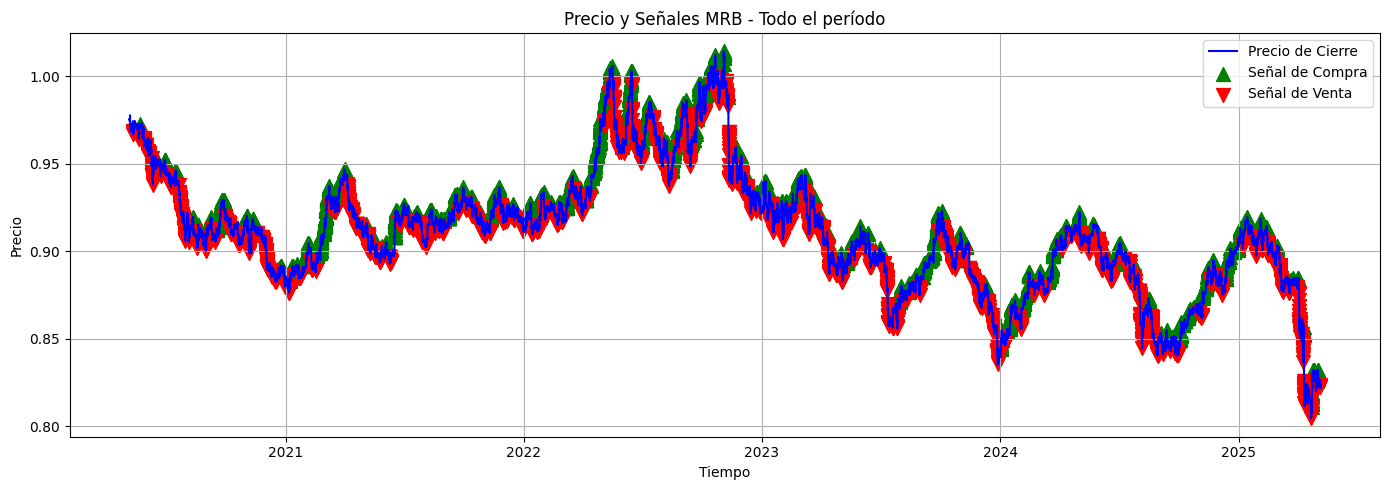

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Precio de cierre (toda la serie)
plt.plot(df['time'], df['close'], label='Precio de Cierre', color='blue')

# Señales MRB en todo el dataset
plt.scatter(df['time'][df['signal'] == 1], df['close'][df['signal'] == 1], 
            label='Señal de Compra', color='green', marker='^', s=100)
plt.scatter(df['time'][df['signal'] == -1], df['close'][df['signal'] == -1], 
            label='Señal de Venta', color='red', marker='v', s=100)

plt.title('Precio y Señales MRB - Todo el período')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



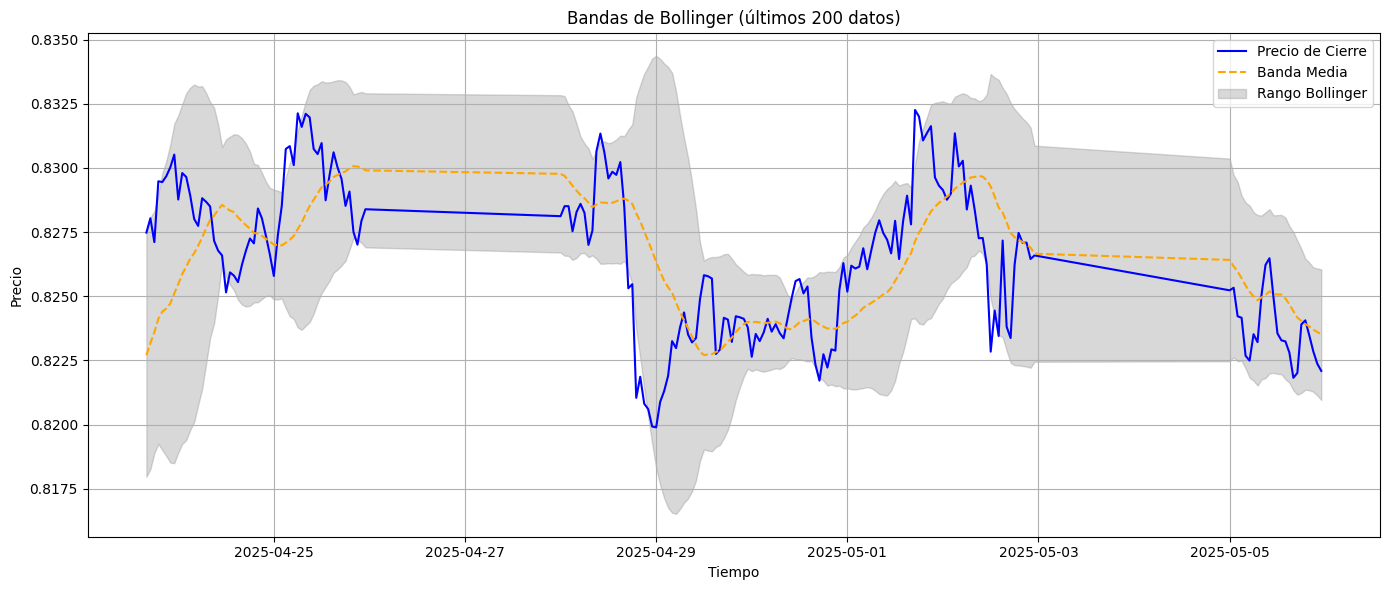

In [7]:
import matplotlib.pyplot as plt

# Últimos N datos para ver más de cerca
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 6))

# Precio de cierre
plt.plot(df_plot['time'], df_plot['close'], label='Precio de Cierre', color='blue', linewidth=1.5)

# Banda media
plt.plot(df_plot['time'], df_plot['bb_middle'], label='Banda Media', color='orange', linestyle='--')

# Relleno entre bandas
plt.fill_between(df_plot['time'], df_plot['bb_lower'], df_plot['bb_upper'], color='gray', alpha=0.3, label='Rango Bollinger')

plt.title('Bandas de Bollinger (últimos 200 datos)')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

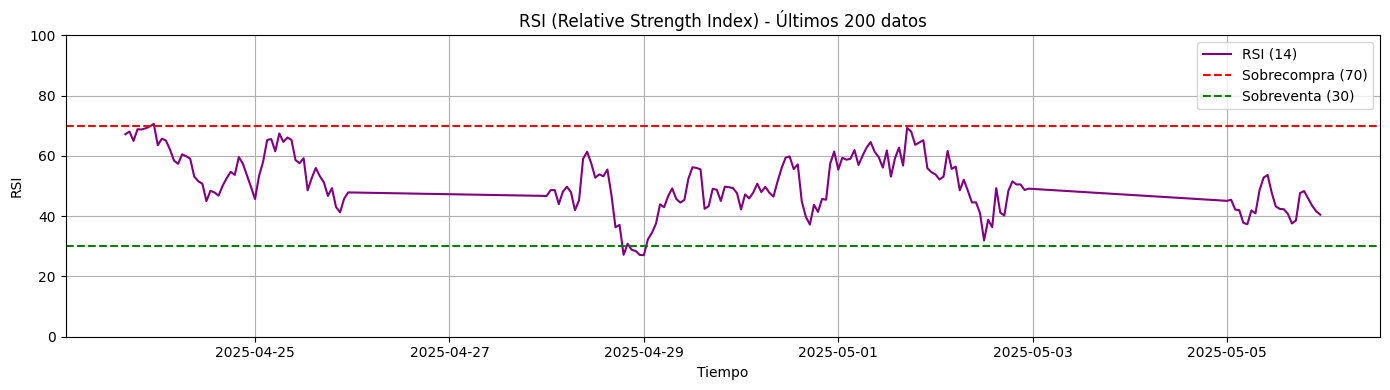

In [8]:
# Últimos N datos para hacer zoom
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 4))

# RSI
plt.plot(df_plot['time'], df_plot['rsi_14'], label='RSI (14)', color='purple', linewidth=1.5)

# Líneas horizontales de referencia
plt.axhline(70, color='red', linestyle='--', label='Sobrecompra (70)')
plt.axhline(30, color='green', linestyle='--', label='Sobreventa (30)')

plt.title('RSI (Relative Strength Index) - Últimos 200 datos')
plt.xlabel('Tiempo')
plt.ylabel('RSI')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


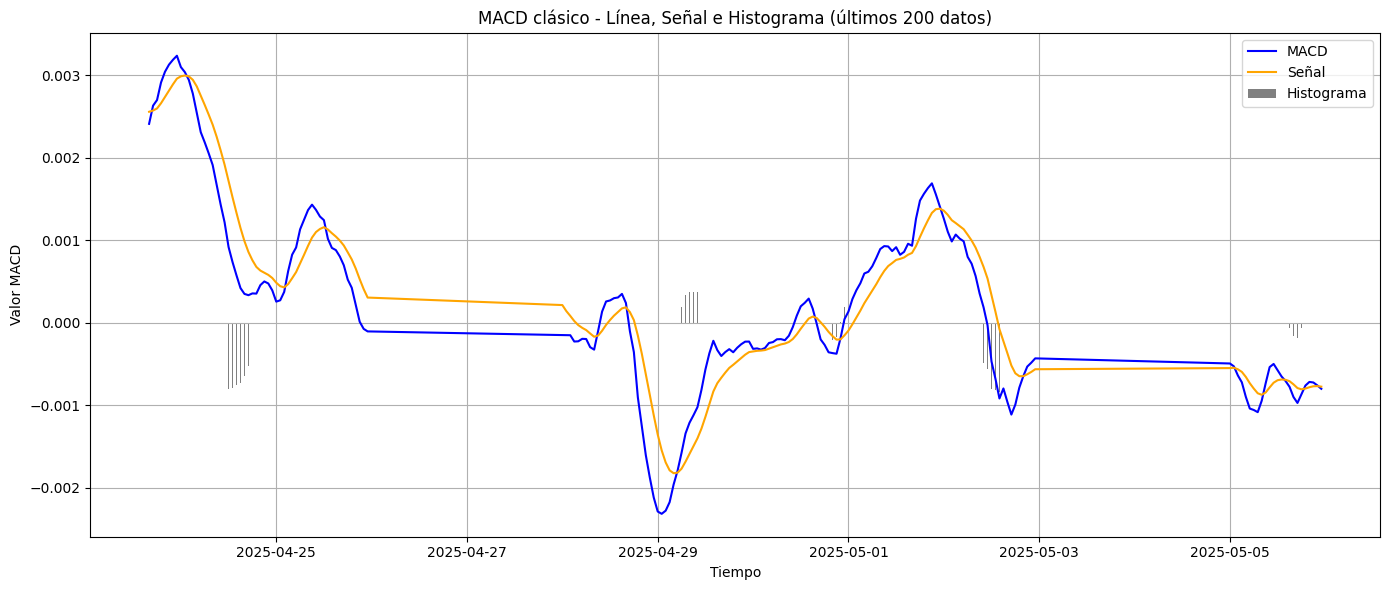

In [9]:
from ta.trend import MACD
# Recalcular MACD completo (no solo diff)
macd_obj = MACD(close=df['close'])
df['macd_line'] = macd_obj.macd()
df['macd_signal'] = macd_obj.macd_signal()
df['macd_histogram'] = macd_obj.macd_diff()

# Tomamos últimos N datos
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 6))

# MACD y señal
plt.plot(df_plot['time'], df_plot['macd_line'], label='MACD', color='blue')
plt.plot(df_plot['time'], df_plot['macd_signal'], label='Señal', color='orange')

# Histograma (barras)
plt.bar(df_plot['time'], df_plot['macd_histogram'], label='Histograma', color='gray', width=0.0015)

plt.title('MACD clásico - Línea, Señal e Histograma (últimos 200 datos)')
plt.xlabel('Tiempo')
plt.ylabel('Valor MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


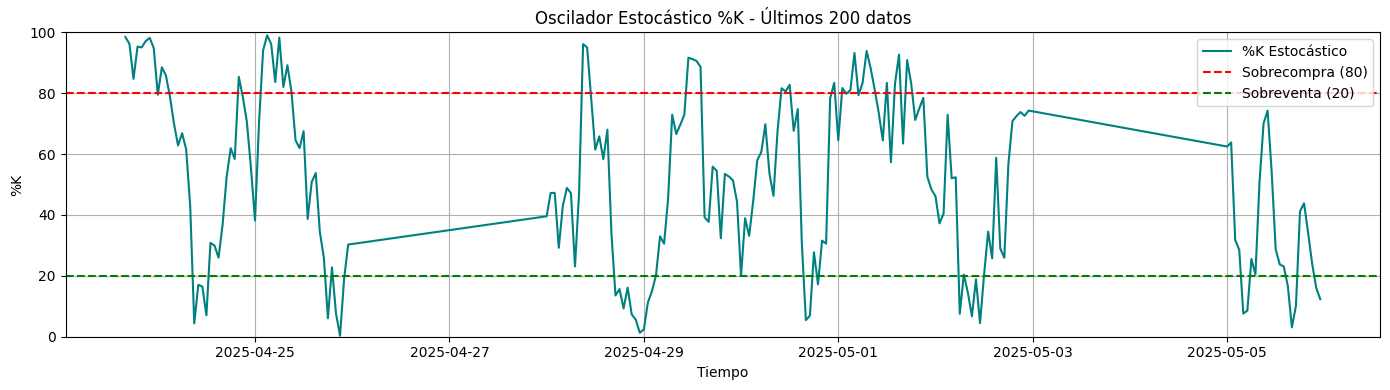

In [10]:
# Últimos N datos
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 4))

# Línea %K
plt.plot(df_plot['time'], df_plot['stoch_k'], label='%K Estocástico', color='teal', linewidth=1.5)

# Zonas de referencia
plt.axhline(80, color='red', linestyle='--', label='Sobrecompra (80)')
plt.axhline(20, color='green', linestyle='--', label='Sobreventa (20)')

plt.title('Oscilador Estocástico %K - Últimos 200 datos')
plt.xlabel('Tiempo')
plt.ylabel('%K')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

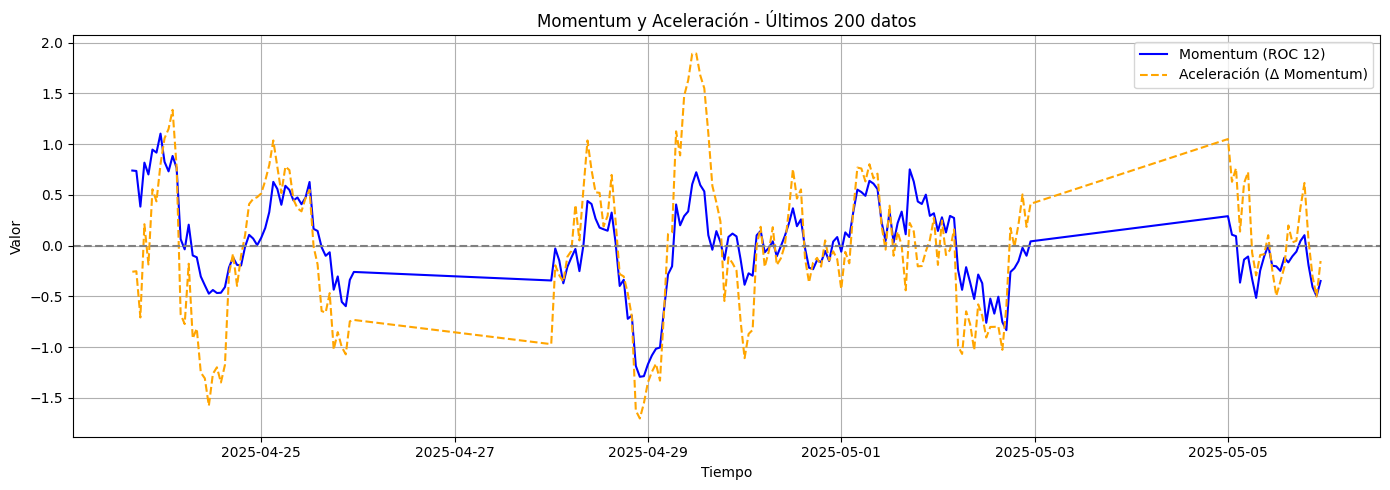

In [11]:
# Últimos N datos
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 5))

# Momentum
plt.plot(df_plot['time'], df_plot['momentum_12'], label='Momentum (ROC 12)', color='blue', linewidth=1.5)

# Aceleración
plt.plot(df_plot['time'], df_plot['acceleration_12'], label='Aceleración (Δ Momentum)', color='orange', linestyle='--', linewidth=1.5)

# Línea cero de referencia
plt.axhline(0, color='gray', linestyle='--')

plt.title('Momentum y Aceleración - Últimos 200 datos')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


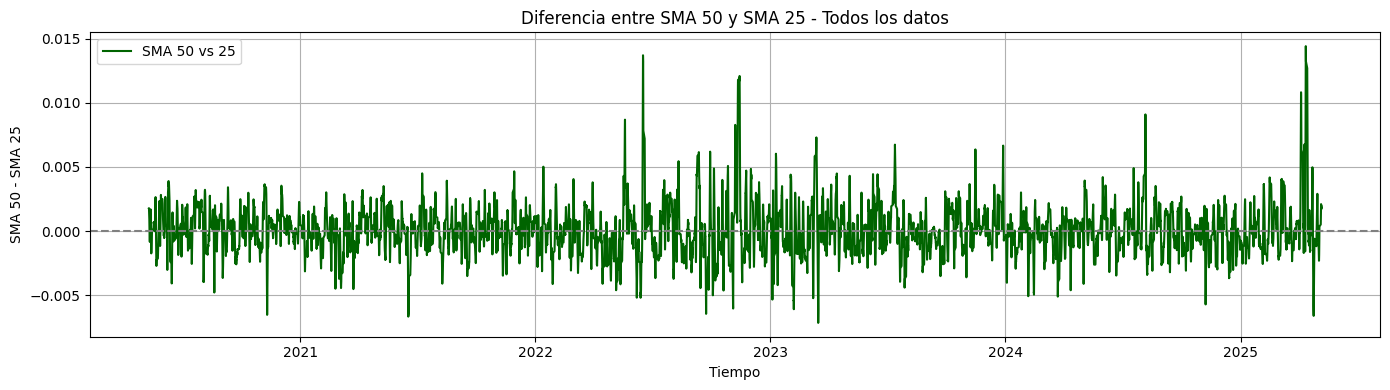

In [12]:
plt.figure(figsize=(14, 4))

# Gráfico para todos los datos
plt.plot(df['time'], df['sma_50_vs_25'], label='SMA 50 vs 25', color='darkgreen', linewidth=1.5)

# Línea cero como referencia
plt.axhline(0, color='gray', linestyle='--')

plt.title('Diferencia entre SMA 50 y SMA 25 - Todos los datos')
plt.xlabel('Tiempo')
plt.ylabel('SMA 50 - SMA 25')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


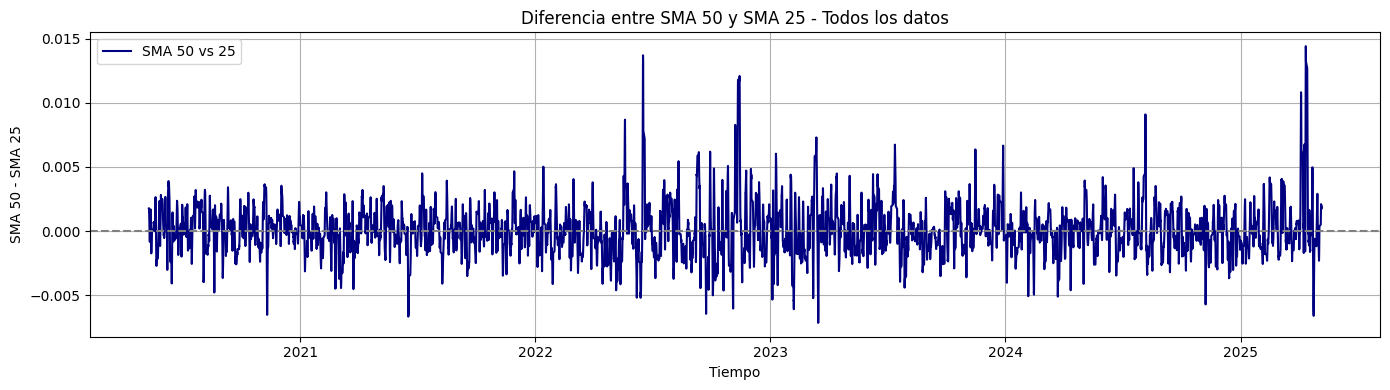

In [13]:
plt.figure(figsize=(14, 4))

# Graficar la diferencia de SMA 50 vs 25 para todos los datos
plt.plot(df['time'], df['sma_50_vs_25'], label='SMA 50 vs 25', color='navy', linewidth=1.5)

# Línea cero como referencia
plt.axhline(0, color='gray', linestyle='--')

plt.title('Diferencia entre SMA 50 y SMA 25 - Todos los datos')
plt.xlabel('Tiempo')
plt.ylabel('SMA 50 - SMA 25')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

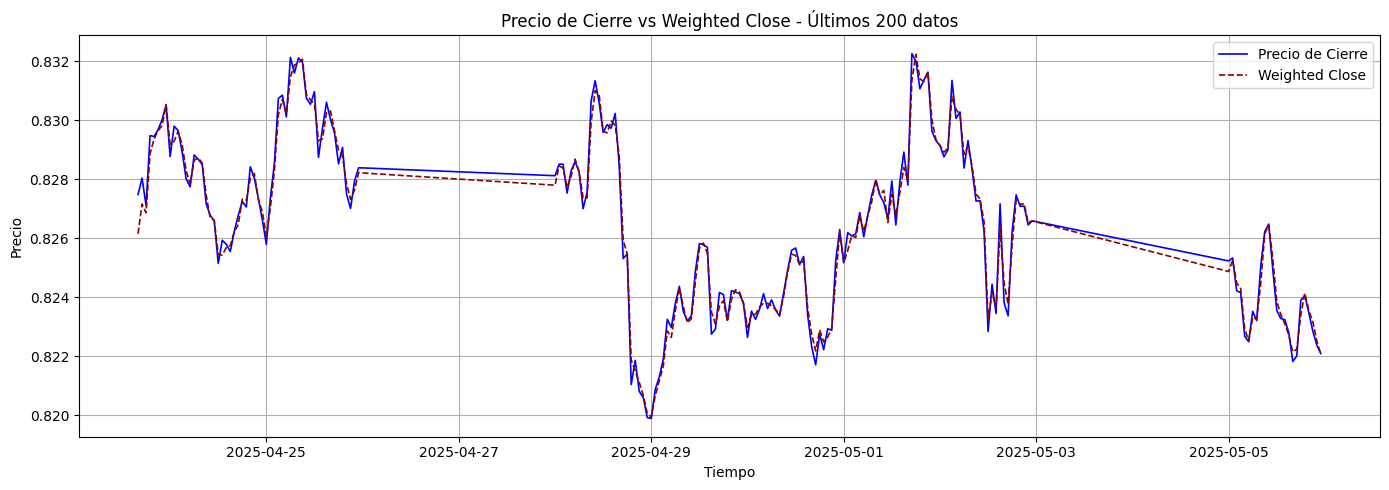

In [14]:
# Últimos N datos
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 5))

# Precio de cierre
plt.plot(df_plot['time'], df_plot['close'], label='Precio de Cierre', color='blue', linewidth=1.2)

# Precio ponderado
plt.plot(df_plot['time'], df_plot['weighted_close'], label='Weighted Close', color='darkred', linestyle='--', linewidth=1.2)

plt.title('Precio de Cierre vs Weighted Close - Últimos 200 datos')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

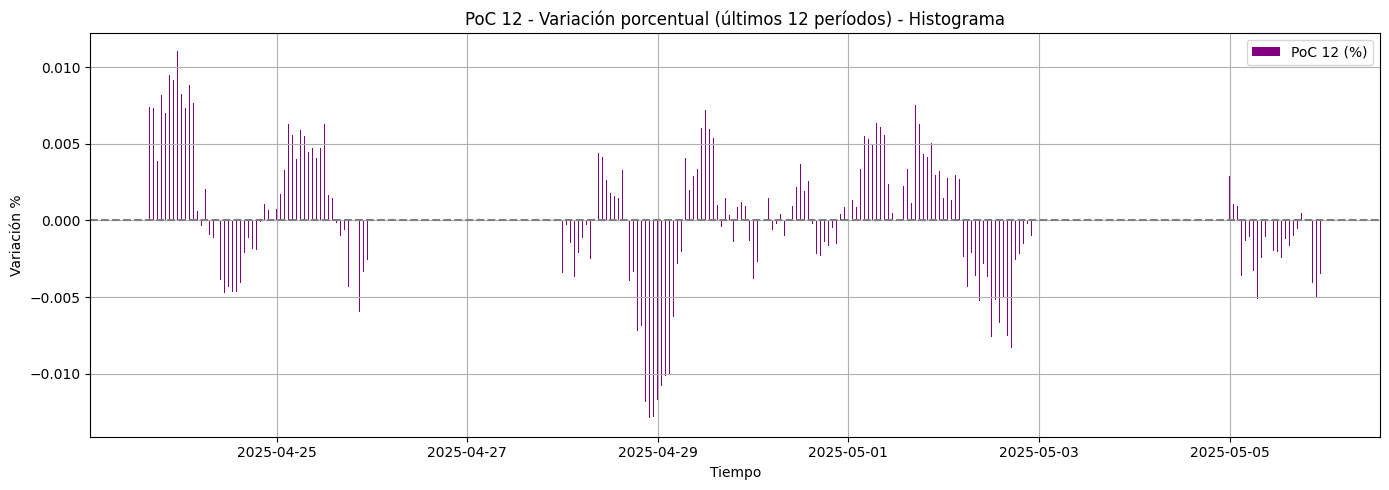

In [15]:
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 5))

# Barras para la variación porcentual
plt.bar(df_plot['time'], df_plot['poc_12'], label='PoC 12 (%)', color='purple', width=0.01)

# Línea cero de referencia
plt.axhline(0, color='gray', linestyle='--')

plt.title('PoC 12 - Variación porcentual (últimos 12 períodos) - Histograma')
plt.xlabel('Tiempo')
plt.ylabel('Variación %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

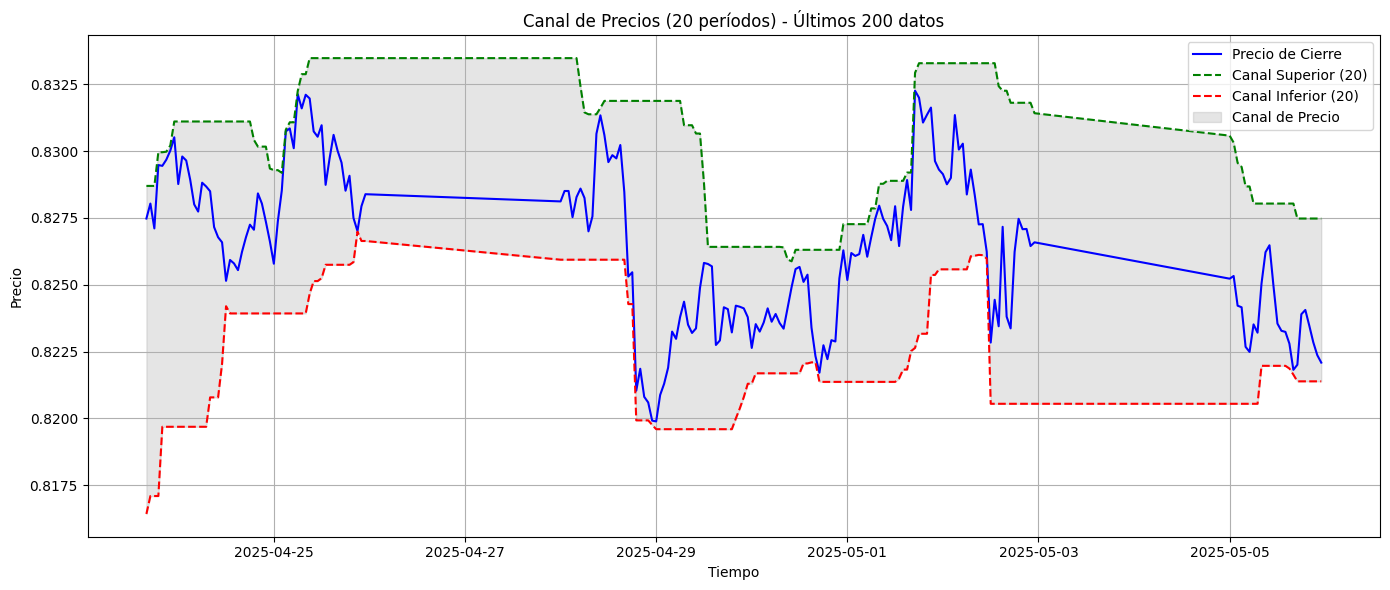

In [16]:
# Últimos N datos
N = 200
df_plot = df.tail(N)

plt.figure(figsize=(14, 6))

# Precio de cierre
plt.plot(df_plot['time'], df_plot['close'], label='Precio de Cierre', color='blue', linewidth=1.5)

# Canal superior e inferior
plt.plot(df_plot['time'], df_plot['high_channel_20'], label='Canal Superior (20)', color='green', linestyle='--')
plt.plot(df_plot['time'], df_plot['low_channel_20'], label='Canal Inferior (20)', color='red', linestyle='--')

# Relleno entre canales
plt.fill_between(df_plot['time'], df_plot['low_channel_20'], df_plot['high_channel_20'], color='gray', alpha=0.2, label='Canal de Precio')

plt.title('Canal de Precios (20 períodos) - Últimos 200 datos')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
